# California Houses Pricing ###

This is a notebook exploring various options of using Sci-kit learn, We try to solve a real-world problem of predicting housing price in the US california state.

This is a Regression problem { as we are trying to predict a house price }

We go through numerous stages, of using Sci-kit learn in this notebook
1. Loading the data
2. Exploring the data
3. Getting insights out of the data
4. Data Cleaning
5. Working with Categorical data
6. Feature Scaling
7. Using Pipelines
8. Selecting a Train Model
9. Using Cross-Validation
10. Saving and Loading Model
11. Fine-Tuning the Model {Using Grid Search, Randomized Search, Ensemble Methods}
12. Evaluation on the Test Set.

Lastly, we will also talk about deployment of this Project and also what are the best practices with it.


# 1. Loading the data

In [1]:
"""
Gnerally the data is located in Databases in froms of multiple tables and one needs to set up a user credentials to
fetch the data from those tables. But in this project we use a simple approach, we download the data in a tgz form and them
decompress it to extract the CSV file.
Generally, its a good practice to write a function to do so, as data is updated regularly.
Also setting up a scheduling routine to automatically update the database is a good practice
"""
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

#function to fetch the data
# function creates a local folder named datasets and fetches the data from the given url and extracts all files into it.
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
# Calling the above function to make the dataset available on the local directory
fetch_housing_data()

In [3]:
#Lets load the data
import pandas as pd
import numpy as np
# function to load the data
def load_housing_data(housing_path= HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
# call the function to load the data
housing = load_housing_data()

In [4]:
# A quick look at the data structure
"""
All the rows represent one district, there are 10 attributes all describe the geogrophical conditions of that district.
The target column here for us to predict is the "median_house_value"
"""
# for detailed overview we can use info() and describe() methods
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


"""
Now if we take a closer look at the data we can see, that the total_bedrooms column has some missing values, as there
are only "20433" values in that column. This means 207 districts do not have this feature. Also the ocean_proximity column
is a object type. Above we could see that it was an categorical attribute. Lets see the categories that exists and see
the value count for each district.
"""

In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


"""
The table above is self explanatory and can give a good feel for what type of data are we dealing with,
one way to see the data in detail is plotting a histogram for all the numerical features.
Lets explore that feature.
"""

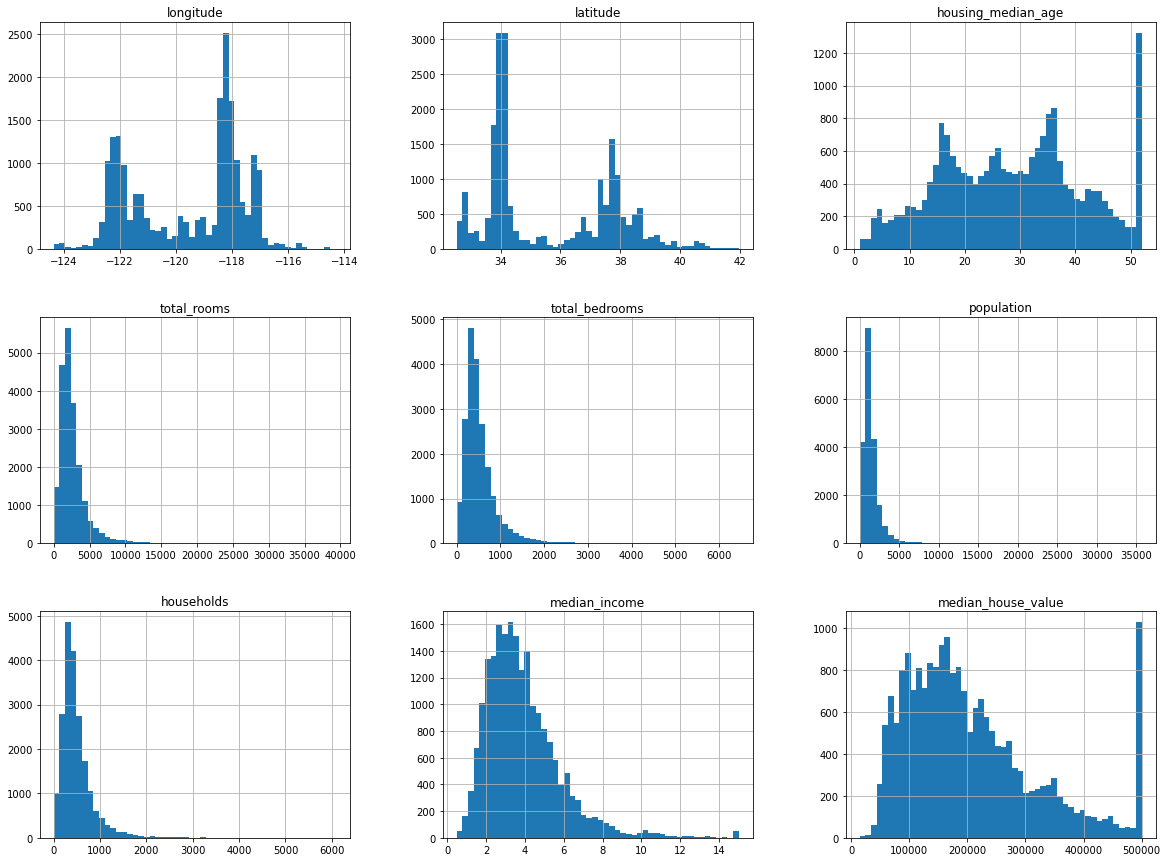

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# 2. Exploring the data

"""
There are several insights that we can take out of these histograms, lets look at some of them,
1. The median_income attribute is not in USD. The data is actually scaled and capped at 15 as 15.00001 for higher
   median incomes and for lower such 0.4999 as 0.5 Which actually means that 3 actually represents $30,000.



2. The housing median age and the median house value are also capped. The later may be a problem they are the target values 
   for our problem. Our algorithm may learn that the house prices do not go beyond that price. Our algorithm should be able    to predict the right prices, even if its above the $500,000. To do so, we have 2 options:
   
   1. Collect proper labels for the districts whose labels were capped
   
   
   2. Remove those districts from the training set and also from the testset, since it shoud not be evaluated poorly if it       performs poorly in predicting values beyond the upper limit.



3. Attributes have different scales, which might cause problems.




4. Many Histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a    bit difficult for some machine learning algorithms to detect pattern. We will try to create a uniform distribution of      the data 
"""

## Before moving ahead its important to create a test set, a set on which we can test if our machine learning model is predicting correctly or not.


In [8]:
" This helps splitting the data, and also provides features to feed in multiple datasets."
from sklearn.model_selection import train_test_split

In [9]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## A quick note on Sampling

Generally a random sampling is ok if the dataset we work on is comparatively large with correspondance to the number of features present. But when dealing with smaller datasets, its important to look at the sampling as it can tremendously introduce sampling bias into the model.

A good example explaining this is introduced in the book " Hands on Machine Learning":
When a survey company decides to call 1000 people for survey, they just dont pick 1000 random people from a telephone directory. They try to ensure that the 1000 people represent the whole population. For example, in US population in 51.3% females and 48.7% males, so a well conducted survey will try to maintain the same ratio into the survey as well. i.e 513 females and 487 males. This is called "Stratified Sampling"

In [10]:
"""
Based on above example, we have to ensure that there is uniformity in the test data that we test our algorithm on,
looking at above histogram its important to understand that the median income category is clustered around 1.5 to 6
but some median range goes beyond 6. It is important to have sufficient number of instances in your dataset for each stratum,
or else the estimate of stratum importance may be biased.


The code below generates an income category attribute with five categories(labeled from 1 to 5), category one ranges from 0 to 1.5,
category two ranges from (1.5 to 3) 
"""

housing['income_cat'] = pd.cut(housing['median_income'], bins=[0.,1.5,3.0,4.5,6.0,np.inf], labels=[1,2,3,4,5])

<AxesSubplot:>

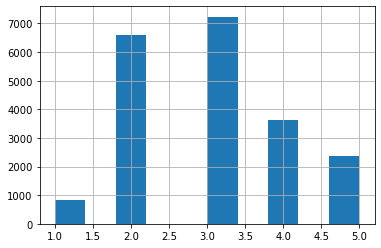

In [11]:
housing['income_cat'].hist()

In [12]:
# Lets lets do a stratifies shuffling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
    

In [13]:
# Now the data is accurately sampled, we need to remove the ['income_cat'] column so that the data is in original form
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# 3. Getting Insights out of Data


In [14]:
"""
 Its a good habit to create a separate set of data for exploration but in our case the dataset is small and we can work
 with it as whole
"""
housing = strat_train_set.copy() #Creating a copy to keep training data unharmed 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

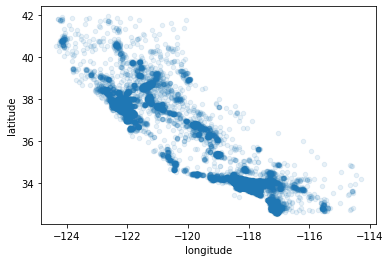

In [15]:
# Visualizing Geaographical Data
housing.plot(kind='scatter', x='longitude',y='latitude', alpha=0.1)

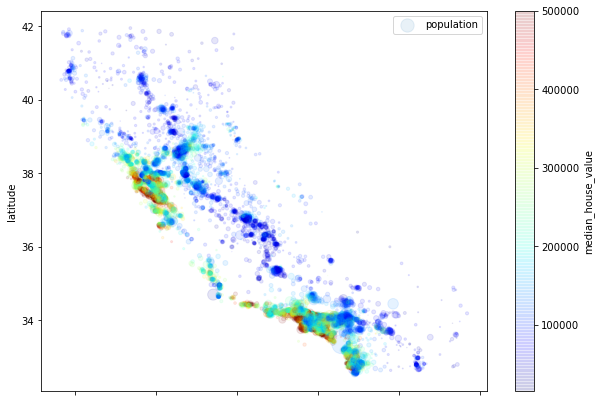

In [16]:
# Now lets create a plot with all the parameter like price, the size and so on
housing.plot(kind='scatter', x='longitude',y='latitude', alpha=0.1,
            s=housing['population']/100, label='population',figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [17]:
"""
Now the exploration tells us that the pricing is generally higher in the coastal areas and in densly populated areas,
which in turn is obvious. But in Northen region, the same trend does not follow so its not that obvious.
"""
# Looking for Correlations between the Attributes.
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

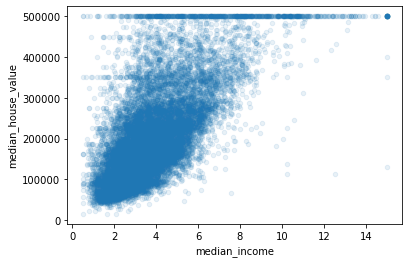

In [18]:
# One other approach is to plot all the numerical values against eacg other and see the corelation,
# Since we have 11 features we will have (11)^2 = 121 plots
"""
Looking at the corelation above we can see that the median income has a high corelation with the median_house_value
Lets explore that relationship further
"""
housing.plot(kind='scatter', x='median_income',y='median_house_value', alpha=0.1)

"""
Looking at the graph above we can see that the price cap can be seen at 500,000, but also there are these other straight lines,
around 280,000, 350,000, and 450,000. We may want to remove these districts so that our model does not learn to reproduce such 
patterns.

"""

In [19]:
"""
One approach that we can try to improve the models performance is to add more attributes, i.e. give the model variables,
that could help it better to make a correct price prediction.

Here are some attributes that we can add, but first lets look at the features we have.

1. So the total_rooms in a district does not give us that much insight but total_rooms in a household would be a good feature
2. Similarly total_bedrooms per household is better than total_beadrooms in a district
3. Household per house is better than household per district.

Lets create this features

"""
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [20]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household']= housing['population']/housing['households']

In [21]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Preparing Data for Machine Learing Algorithm

In [22]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

# 4. Data Cleaning

In [23]:
"""
Most machine learning algorithms cannot work with missing values, so lets create a few functions that can take care 
of that.
We noticed that the total_bedrooms has some missing values.

We have 3 ways to deal with this problem:
1. Get rid of the corresponding districts
2. Get rid of the whole attribute
3. Set the values to some value (0, mean, median etc)
"""
# Lets use the scikit learn simpleimputer to replace the values using 3rd option
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

"""
Since the median can be calculated over all numerical attributes , we need to remove the ocean_proximity feature.
"""
housing_numerical = housing.drop('ocean_proximity', axis=1)

In [24]:
# Lets fit the data into the imputer
imputer.fit(housing_numerical)
"""
Now when we train the imputer, it calculated median for all the features and saves it in its statistics_ instance as 
a numpy array.

Now lets transform the data by using the trained imputer
"""
X = imputer.transform(housing_numerical)
"""
The result is a simple numpy array containing tranformed features. Lets put it back into a Dataframe
"""
housing_tr = pd.DataFrame(X, columns=housing_numerical.columns, index=housing_numerical.index)

# 5. Working with Categorical Data

In [25]:
"""
Most Machine learning Algorithm work with Numeric Data but we have one feature with categorical data,
lets take a look at them
"""
Categorical_val = housing[['ocean_proximity']]


"""
There are limited number of Categories, so we can convert them into numerical values.
We have two options to do so.
1. OrdinalEncoder
2. OneHotEncoder

We will work with OneHotEncoder
"""
Categorical_val.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [26]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit(Categorical_val)

## Custom Transformers

In [27]:
# Here we write a function which performs the above tasks of adding the attributes.

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

room_ix, bedroom_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, room_ix]/X[:,household_ix]
        population_per_household = X[:,population_ix]/X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedroom_ix]/X[:,room_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# 6. Feature Scaling

"""
One of the most important transformation is the Feature scaling. Machine Learning Algorithms do not work well if the input
numerical data is of varying scale. In case of our housing data, the total rooms vary from 6 to 39,320, while the median
income only ranges from 0-15.

NOTE: Scaling the target values is not generally required.

For scaling the features we have two options:
1. MinMax Scaler: Also called Normalization, what it does is it rescales and shifts the value to range between 0-1.
We do this by subtracting the min value and then dividing by the max - min.

2. StandardScaler: This subtracts the mean value and then divides by the Standard deviation. This type of scaling does not 
let the data get affected by outliers.

"""

"""
As there are many data transformation steps that need to be executedin the right order. This is where we use Pipelines
"""
# 7. Pipelines

In [29]:
# Lets write a small pipeline for all the numerical attributed in our dataset
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
"""
This way we can write a custom pipeline with series of transformation for numerical data, its easier than doing each step
individually and also it is helpful when we have new data in the dataset.
"""
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribute_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_numerical_transformed = numerical_pipeline.fit_transform(housing_numerical)

In [30]:
# Sofar we have handelled the numerical and categorical data separately, but in Sci-kit learn we can work with both together
from sklearn.compose import ColumnTransformer

num_attributes = list(housing_numerical)
cat_attributes = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes),
])

housing_prepared = full_pipeline.fit_transform(housing)

# 8. Select and Train a Model

In [31]:
"""
We have framed the problem, cleaned our data and also prepared it to feed it into a machine leaning algorithm, the next step
is to select a model and then train it to make predictions!
"""
# Lets train a Linear Regression Model First
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression()
lin_reg_model.fit(housing_prepared, housing_labels)

LinearRegression()

In [32]:
# Now we have a trained Linear Regression model, lets check out on some instances from the training data
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions: ', lin_reg_model.predict(some_data_prepared))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [33]:
# Lets observe the metrics
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg_model.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

The median housing prices range from 120,000$  to 265,000$ and an error of 68,628$ is not very satisfying.
The problem we have here is a model underfitting the training data.

Reasons for Underfitting:

1. The features do not provide enough information for the model to make the right predictions, or that the model is not powerful enough.

How to solve the Underfitting problem

1. Try adding more features (eg. Logarithm of the features )
2. Try to reduce the constrains of the model
3. Try a more complex model


In [34]:
# Lets train a more complex model which is capable of learing more non-linear features in the data
from sklearn.tree import DecisionTreeRegressor

tree_regressor_model = DecisionTreeRegressor()
tree_regressor_model.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [35]:
# Now we have a trained DecisionTressRegressor model, lets check its performance on the training data

housing_predictions_by_tree = tree_regressor_model.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions_by_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Well 0.0 Error that seems like a perfect model isn't it but it isn't. Ofcourse it can be true but its also possible that the model badly ovefit the training data.

We cannot test the model until we are sure about the model, so we need a part of trainig set to validate the model,
this part is called the "Validation Set"

A great way to do this is use Sklearns's "K-Fold" method.
The following code splits the training data into 10 splits called folds, then it trains and evaluates the model 10 times, picking a different fold to evaluate everytime and train on the other 9


# 9. Using Cross-Validation 

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_regressor_model, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [37]:
# Lets write a fuunction to display the scores
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean of Scores', scores.mean())
    print('Std of Scores', scores.std())
    

In [38]:
display_scores(tree_rmse_scores)

Scores:  [68274.37245716 64865.27660749 69500.25622036 68199.07824574
 69656.7000454  74774.92626611 70702.84022089 70721.67396854
 76383.69728672 70543.5522029 ]
Mean of Scores 70362.23735213144
Std of Scores 3106.5043408297092


In [39]:
"""
If we see the scores we can observe that the DecisionTree model performed worse than the Linear Model.
The decision tree is badly overfitting the data.
Lets use Cross Validation on the Linear model
"""
lin_model_scores = cross_val_score(lin_reg_model, housing_prepared, housing_labels,
                                  scoring='neg_mean_squared_error', cv=10)
lin_model_rmse_scores = np.sqrt(-lin_model_scores)
display_scores(lin_model_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean of Scores 69052.46136345083
Std of Scores 2731.6740017983493


In [40]:
"""
Well definately the Linear regression is better than the Decision Tree but its still bad to be used.

Lets try one other model, RandomForestRegressor.
What this Algorithm does is it trains numerous Decision Tress on random subsets of the features, then averaging out predictions

"""
from sklearn.ensemble import RandomForestRegressor
forest_reg_model = RandomForestRegressor()
forest_reg_model.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [41]:
# Now that we have the model trained, lets check its performance using Kfolds
forest_reg_model_scores = cross_val_score(forest_reg_model, housing_prepared, housing_labels,
                                         scoring='neg_mean_squared_error', cv=10)
forest_reg_model_rmse_scores = np.sqrt(-forest_reg_model_scores)
display_scores(forest_reg_model_rmse_scores)

Scores:  [49764.32171312 47563.02003095 49778.53060685 52225.13288484
 49546.17608728 53314.35953564 48576.70250281 48411.03114021
 53149.37699035 50902.51004585]
Mean of Scores 50323.11615378862
Std of Scores 1908.5406223536613


# 10. Saving and Loading Model

In [42]:
"""
Well this model is performing better than the other two, but still is slightly overfitting. We can tell that by noticing the 
score on the training data and on the validation data. The scores here are lower on the training set ,whereas higher on the 
validation set.
"""
# Lets us save the Random Forest Regressor Model so that we could come back to it later and tune it to perform better
import joblib
joblib.dump(forest_reg_model, 'Random_reg_model.pkl')

['Random_reg_model.pkl']

In [43]:
# Loading the model

forest_reg_model = joblib.load('Random_reg_model.pkl')

# 11. Fine Tune the Model


In [44]:
"""
One of the option is to try out numerous parameters and find the best one. But it can be time consuming and also very
tedious. One option is to explore using GridSearchCV
"""
"""
What GridSearchCV expects is a list of hyperparameters, that you want the system to test. It will test the combinations
using the Cross-Validation and give out the best parameters.

"""
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    
]

In [45]:
forest_regressor = RandomForestRegressor()

grid_search = GridSearchCV(forest_regressor, param_grid, cv=5,
                          scoring='neg_mean_squared_error', return_train_score=True)

In [46]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [47]:
# now to check which parameter was the best 
grid_search.best_params_

# We can see that the best parameters are the max one that we gave in so we could try others as well as there might be room
# for improvement

{'max_features': 8, 'n_estimators': 30}

In [48]:
# We can also obtain the best estimator direcrtly
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [49]:
#  The evaluations scores can also be seen directly
cvres = grid_search.cv_results_
for mean_scores, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_scores), params)

64044.47452158328 {'max_features': 2, 'n_estimators': 3}
55240.849772797366 {'max_features': 2, 'n_estimators': 10}
52721.58708664202 {'max_features': 2, 'n_estimators': 30}
60405.041871328795 {'max_features': 4, 'n_estimators': 3}
53078.438384736386 {'max_features': 4, 'n_estimators': 10}
50683.25850191375 {'max_features': 4, 'n_estimators': 30}
59262.964858258274 {'max_features': 6, 'n_estimators': 3}
52367.19556147397 {'max_features': 6, 'n_estimators': 10}
50212.84450509585 {'max_features': 6, 'n_estimators': 30}
58629.802623722346 {'max_features': 8, 'n_estimators': 3}
52622.84805203836 {'max_features': 8, 'n_estimators': 10}
49994.229477669774 {'max_features': 8, 'n_estimators': 30}
62487.678283301364 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54209.173841023156 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60180.41125721707 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53094.758124997876 {'bootstrap': False, 'max_features': 3, 'n_estima

Now we can see that we were able to fine tune the model by finding the best parameters. The value by default parameters was "50,182" but after fine tuning the model with the best parameters we have the rmse values of 49,885.
This is one of the steps we can use when we have certain specified number of hypermeters we want to try, but what if there are numerous values of hyperparameters and we want to look for their values. 

Another approach to fine tune your model by finding the best estimators is using
### Randomized Search


In [50]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                  n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                  random_state=42)
random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CC8F08F388>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CC8F08FE08>},
                   random_state=42, scoring='neg_mean_squared_error')

The advantage of this method are following:

1. If we let the randomized search run for say 1000 iterations, this approach will explore 1000 different values for each hyperparameter.

2. Simply by providig number of iterations we have more control over the computing we want to allocate to the hyperparameter.

### Analyze the best models and their Errors
We often get good insights about the problem by evaluating the best model,

for example for our RandomRegressor model we can see which feature is more important in order to make the right predictions


In [52]:
feature_importance = grid_search.best_estimator_.feature_importances_
# Lets show the following feature importance
extra_attributes = ['rooms_per_hold','popul_per_household','bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attributes + extra_attributes + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.3761774900108524, 'median_income'),
 (0.1525620599543038, 'INLAND'),
 (0.11318374156078895, 'popul_per_household'),
 (0.07314628031033907, 'longitude'),
 (0.06354108655432927, 'latitude'),
 (0.05864831635693453, 'bedrooms_per_room'),
 (0.05096067754052124, 'rooms_per_hold'),
 (0.0413678922510184, 'housing_median_age'),
 (0.015047552925857816, 'population'),
 (0.014723385237897563, 'total_rooms'),
 (0.014533658716886977, 'households'),
 (0.01419176729914625, 'total_bedrooms'),
 (0.005936623783787073, '<1H OCEAN'),
 (0.0029959717448245536, 'NEAR BAY'),
 (0.0029060137346972052, 'NEAR OCEAN'),
 (7.748201781495871e-05, 'ISLAND')]

As we can see, that the most important feature is the "median_income" feature. We can also drop numerous features such as 
options from "Ocean_proximity". Only one of that feature is actually helping the model.

# 12. Evaluation on Test Data

In [53]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [54]:
final_rmse

47619.42174643401

# A complete pipeline with both preparation and prediction



In [55]:
full_pipeline_with_predictor = Pipeline([
    ('preparation', full_pipeline),
    ('RandomRegressor',RandomForestRegressor())
])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([260994.  , 324831.02, 214403.  ,  52460.  , 235596.  ])

# Model Persistance

In [56]:
my_model = full_pipeline_with_predictor

joblib.dump(my_model, "my_final_predicting_model.pkl")

['my_final_predicting_model.pkl']